##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# int16 활성화를 사용한 훈련 후 정수 양자화

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant_16x8"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_integer_quant_16x8.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_integer_quant_16x8.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/performance/post_training_integer_quant_16x8.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 개요

[TensorFlow Lite](https://www.tensorflow.org/lite/)는 이제 TensorFlow에서 TensorFlow Lite의 플랫 버퍼 형식으로 모델을 변환하는 동안 활성화를 16bit 정수 값으로, 가중치를 8bit 정수 값으로 변환하는 작업을 지원합니다. 이 모드를 "16x8 양자화 모드"라고 합니다. 이 모드는 활성화가 양자화에 민감할 때 양자화된 모델의 정확성을 크게 향상시키면서도 모델 크기를 거의 3 ~ 4배 줄일 수 있습니다. 또한 이 완전 양자화된 모델은 정수 전용 하드웨어 가속기에서 사용할 수 있습니다.

이 훈련 후 양자화 모드의 이점을 얻는 모델의 몇 가지 예는 다음과 같습니다.

- 초고해상도
- 소음 상쇄 및 빔포밍과 같은 오디오 신호 처리
- 이미지 노이즈 제거
- 단일 이미지에서 HDR 재구성

이 튜토리얼에서는 MNIST 모델을 처음부터 학습시키고 TensorFlow에서 정확성을 확인한 다음, 이 모드를 사용하여 모델을 Tensorflow Lite 플랫 버퍼로 변환합니다. 마지막으로, 변환된 모델의 정확성을 확인하고 원래 float32 모델과 비교합니다. 이 예제는 이 모드의 사용법을 보여주는 것이며 TensorFlow Lite에서 사용 가능한 다른 양자화 기술과 비교한 이점을 보여주지는 않습니다.

## MNIST 모델 빌드하기

### 설정

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

2022-12-15 00:58:13.702544: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 00:58:13.702639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 00:58:13.702648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


16x8 양자화 모드를 사용할 수 있는지 확인합니다. 

In [3]:
tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8

<OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8: 'EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8'>

### 모델 훈련 및 내보내기

In [4]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

   1/1875 [..............................] - ETA: 1:17:48 - loss: 2.3468 - accuracy: 0.0312

  20/1875 [..............................] - ETA: 5s - loss: 2.1178 - accuracy: 0.3266     

  40/1875 [..............................] - ETA: 4s - loss: 1.8337 - accuracy: 0.5102

  60/1875 [..............................] - ETA: 4s - loss: 1.5593 - accuracy: 0.5974

  81/1875 [>.............................] - ETA: 4s - loss: 1.3492 - accuracy: 0.6512

 103/1875 [>.............................] - ETA: 4s - loss: 1.1769 - accuracy: 0.6936

 125/1875 [=>............................] - ETA: 4s - loss: 1.0659 - accuracy: 0.7185

 146/1875 [=>............................] - ETA: 4s - loss: 0.9814 - accuracy: 0.7369

 168/1875 [=>............................] - ETA: 4s - loss: 0.9075 - accuracy: 0.7545

 189/1875 [==>...........................] - ETA: 4s - loss: 0.8596 - accuracy: 0.7657

 210/1875 [==>...........................] - ETA: 4s - loss: 0.8099 - accuracy: 0.7781

 232/1875 [==>...........................] - ETA: 4s - loss: 0.7668 - accuracy: 0.7893

 254/1875 [===>..........................] - ETA: 3s - loss: 0.7369 - accuracy: 0.7970

 275/1875 [===>..........................] - ETA: 3s - loss: 0.7085 - accuracy: 0.8040

 297/1875 [===>..........................] - ETA: 3s - loss: 0.6852 - accuracy: 0.8110

 319/1875 [====>.........................] - ETA: 3s - loss: 0.6611 - accuracy: 0.8171

 340/1875 [====>.........................] - ETA: 3s - loss: 0.6410 - accuracy: 0.8214

 361/1875 [====>.........................] - ETA: 3s - loss: 0.6246 - accuracy: 0.8255

 383/1875 [=====>........................] - ETA: 3s - loss: 0.6105 - accuracy: 0.8290

 404/1875 [=====>........................] - ETA: 3s - loss: 0.5967 - accuracy: 0.8328

 425/1875 [=====>........................] - ETA: 3s - loss: 0.5834 - accuracy: 0.8366

 445/1875 [======>.......................] - ETA: 3s - loss: 0.5705 - accuracy: 0.8400

 466/1875 [======>.......................] - ETA: 3s - loss: 0.5583 - accuracy: 0.8435

 488/1875 [======>.......................] - ETA: 3s - loss: 0.5500 - accuracy: 0.8448

 510/1875 [=======>......................] - ETA: 3s - loss: 0.5402 - accuracy: 0.8467

 532/1875 [=======>......................] - ETA: 3s - loss: 0.5320 - accuracy: 0.8490

 553/1875 [=======>......................] - ETA: 3s - loss: 0.5220 - accuracy: 0.8514

 575/1875 [========>.....................] - ETA: 3s - loss: 0.5154 - accuracy: 0.8535

 596/1875 [========>.....................] - ETA: 3s - loss: 0.5083 - accuracy: 0.8560

 617/1875 [========>.....................] - ETA: 3s - loss: 0.5014 - accuracy: 0.8576

 637/1875 [=========>....................] - ETA: 2s - loss: 0.4965 - accuracy: 0.8591

 658/1875 [=========>....................] - ETA: 2s - loss: 0.4893 - accuracy: 0.8610

 679/1875 [=========>....................] - ETA: 2s - loss: 0.4831 - accuracy: 0.8624

 699/1875 [==========>...................] - ETA: 2s - loss: 0.4773 - accuracy: 0.8639

 720/1875 [==========>...................] - ETA: 2s - loss: 0.4714 - accuracy: 0.8653

 742/1875 [==========>...................] - ETA: 2s - loss: 0.4656 - accuracy: 0.8670

 763/1875 [===========>..................] - ETA: 2s - loss: 0.4610 - accuracy: 0.8682

 784/1875 [===========>..................] - ETA: 2s - loss: 0.4571 - accuracy: 0.8695

 805/1875 [===========>..................] - ETA: 2s - loss: 0.4515 - accuracy: 0.8710

 825/1875 [============>.................] - ETA: 2s - loss: 0.4468 - accuracy: 0.8722

 845/1875 [============>.................] - ETA: 2s - loss: 0.4426 - accuracy: 0.8735

 866/1875 [============>.................] - ETA: 2s - loss: 0.4383 - accuracy: 0.8747

 887/1875 [=============>................] - ETA: 2s - loss: 0.4342 - accuracy: 0.8760

 908/1875 [=============>................] - ETA: 2s - loss: 0.4305 - accuracy: 0.8771

 929/1875 [=============>................] - ETA: 2s - loss: 0.4259 - accuracy: 0.8783

 951/1875 [==============>...............] - ETA: 2s - loss: 0.4214 - accuracy: 0.8795

 972/1875 [==============>...............] - ETA: 2s - loss: 0.4174 - accuracy: 0.8807

 992/1875 [==============>...............] - ETA: 2s - loss: 0.4132 - accuracy: 0.8819

1012/1875 [===============>..............] - ETA: 2s - loss: 0.4104 - accuracy: 0.8827

1033/1875 [===============>..............] - ETA: 2s - loss: 0.4078 - accuracy: 0.8833

1054/1875 [===============>..............] - ETA: 1s - loss: 0.4043 - accuracy: 0.8845

1075/1875 [================>.............] - ETA: 1s - loss: 0.4014 - accuracy: 0.8853

1096/1875 [================>.............] - ETA: 1s - loss: 0.3984 - accuracy: 0.8864

1117/1875 [================>.............] - ETA: 1s - loss: 0.3959 - accuracy: 0.8870

1138/1875 [=================>............] - ETA: 1s - loss: 0.3923 - accuracy: 0.8879

1159/1875 [=================>............] - ETA: 1s - loss: 0.3903 - accuracy: 0.8883

1180/1875 [=================>............] - ETA: 1s - loss: 0.3877 - accuracy: 0.8892

1201/1875 [==================>...........] - ETA: 1s - loss: 0.3854 - accuracy: 0.8898

1222/1875 [==================>...........] - ETA: 1s - loss: 0.3828 - accuracy: 0.8905

1242/1875 [==================>...........] - ETA: 1s - loss: 0.3794 - accuracy: 0.8915

1263/1875 [===================>..........] - ETA: 1s - loss: 0.3764 - accuracy: 0.8924

1284/1875 [===================>..........] - ETA: 1s - loss: 0.3740 - accuracy: 0.8930

1306/1875 [===================>..........] - ETA: 1s - loss: 0.3709 - accuracy: 0.8938

1327/1875 [====================>.........] - ETA: 1s - loss: 0.3692 - accuracy: 0.8945

1349/1875 [====================>.........] - ETA: 1s - loss: 0.3673 - accuracy: 0.8950

1371/1875 [====================>.........] - ETA: 1s - loss: 0.3644 - accuracy: 0.8959

1393/1875 [=====================>........] - ETA: 1s - loss: 0.3617 - accuracy: 0.8967

1414/1875 [=====================>........] - ETA: 1s - loss: 0.3595 - accuracy: 0.8972

1435/1875 [=====================>........] - ETA: 1s - loss: 0.3568 - accuracy: 0.8979

1456/1875 [======================>.......] - ETA: 1s - loss: 0.3542 - accuracy: 0.8988

1477/1875 [======================>.......] - ETA: 0s - loss: 0.3523 - accuracy: 0.8993

1499/1875 [======================>.......] - ETA: 0s - loss: 0.3501 - accuracy: 0.8999

1521/1875 [=======================>......] - ETA: 0s - loss: 0.3475 - accuracy: 0.9006

1542/1875 [=======================>......] - ETA: 0s - loss: 0.3453 - accuracy: 0.9012

1563/1875 [========================>.....] - ETA: 0s - loss: 0.3431 - accuracy: 0.9019

1584/1875 [========================>.....] - ETA: 0s - loss: 0.3404 - accuracy: 0.9028

1605/1875 [========================>.....] - ETA: 0s - loss: 0.3381 - accuracy: 0.9035

1627/1875 [=========================>....] - ETA: 0s - loss: 0.3362 - accuracy: 0.9040

1648/1875 [=========================>....] - ETA: 0s - loss: 0.3345 - accuracy: 0.9046

1669/1875 [=========================>....] - ETA: 0s - loss: 0.3330 - accuracy: 0.9051

1691/1875 [==========================>...] - ETA: 0s - loss: 0.3312 - accuracy: 0.9055

1712/1875 [==========================>...] - ETA: 0s - loss: 0.3288 - accuracy: 0.9062

1734/1875 [==========================>...] - ETA: 0s - loss: 0.3272 - accuracy: 0.9066

1756/1875 [===========================>..] - ETA: 0s - loss: 0.3252 - accuracy: 0.9071

1778/1875 [===========================>..] - ETA: 0s - loss: 0.3235 - accuracy: 0.9075

1799/1875 [===========================>..] - ETA: 0s - loss: 0.3219 - accuracy: 0.9080

1820/1875 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.9083

1841/1875 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.9088

1862/1875 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.9092

1875/1875 [==============================] - 8s 3ms/step - loss: 0.3165 - accuracy: 0.9095 - val_loss: 0.1584 - val_accuracy: 0.9553


예를 들어, 단일 epoch에 대해서만 모델을 훈련시켰으므로 ~96% 정확성으로만 훈련합니다.

### TensorFlow Lite 모델로 변환하기

TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert)를 사용하여 이제 훈련된 모델을 TensorFlow Lite 모델로 변환할 수 있습니다.

이제 `TFliteConverter`를 사용하여 모델을 기본 float32 형식으로 변환합니다.

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmplvt0uukx/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmplvt0uukx/assets


2022-12-15 00:58:28.021632: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:58:28.021671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


`.tflite` 파일에 작성합니다.

In [6]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [7]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84820

대신 모델을 16x8 양자화 모드로 양자화하려면 먼저 기본 최적화를 사용하도록 `optimizations` 플래그를 설정합니다. 그런 다음 16x8 양자화 모드가 대상 사양에서 지원되는 필수 연산임을 지정합니다.

In [8]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

int8 훈련 후 양자화의 경우와 마찬가지로, 변환기 옵션 `inference_input(output)_type`을 tf.int16으로 설정하여 완전히 정수 양자화된 모델을 생성할 수 있습니다.

보정 데이터를 설정합니다.

In [9]:
mnist_train, _ = tf.keras.datasets.mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]
converter.representative_dataset = representative_data_gen

마지막으로, 평소와 같이 모델을 변환합니다. 기본적으로 변환된 모델은 호출 편의를 위해 여전히 float 입력 및 출력을 사용합니다.

In [10]:
tflite_16x8_model = converter.convert()
tflite_model_16x8_file = tflite_models_dir/"mnist_model_quant_16x8.tflite"
tflite_model_16x8_file.write_bytes(tflite_16x8_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpiqja0kzc/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpiqja0kzc/assets


2022-12-15 00:58:29.502394: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:58:29.502436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


24960

결과 파일이 약 `1/3` 크기인 것에 주목합니다.

In [11]:
!ls -lh {tflite_models_dir}

total 156K
-rw-rw-r-- 1 kbuilder kbuilder 83K Dec 15 00:58 mnist_model.tflite
-rw-rw-r-- 1 kbuilder kbuilder 25K Dec 15 00:58 mnist_model_quant_16x8.tflite
-rw-rw-r-- 1 kbuilder kbuilder 44K Dec 15 00:56 mnist_model_quant_f16.tflite


## TensorFlow Lite 모델 실행하기

Python TensorFlow Lite 인터프리터를 사용하여 TensorFlow Lite 모델을 실행합니다.

### 인터프리터에 모델 로드하기

In [12]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
interpreter_16x8 = tf.lite.Interpreter(model_path=str(tflite_model_16x8_file))
interpreter_16x8.allocate_tensors()

### 하나의 이미지에서 모델 테스트하기

In [14]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

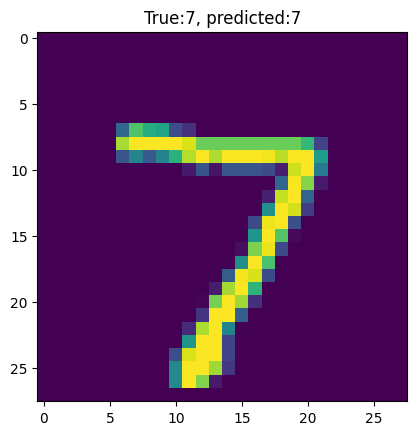

In [15]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [16]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_16x8.get_input_details()[0]["index"]
output_index = interpreter_16x8.get_output_details()[0]["index"]

interpreter_16x8.set_tensor(input_index, test_image)
interpreter_16x8.invoke()
predictions = interpreter_16x8.get_tensor(output_index)

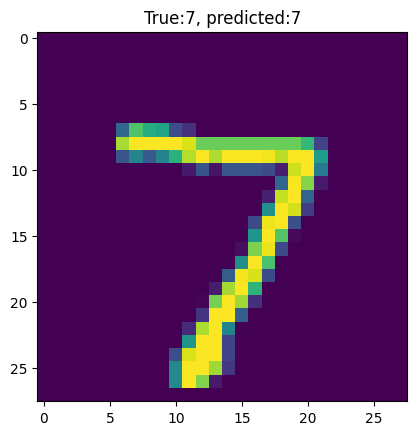

In [17]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### 모델 평가하기

In [18]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [19]:
print(evaluate_model(interpreter))

0.9553


16x8 양자화된 모델에 대해 평가를 반복합니다.

In [20]:
# NOTE: This quantization mode is an experimental post-training mode,
# it does not have any optimized kernels implementations or
# specialized machine learning hardware accelerators. Therefore,
# it could be slower than the float interpreter.
print(evaluate_model(interpreter_16x8))

0.9554


이 예에서는 정확성에 차이가 없지만 3배 축소된 크기로 모델을 16x8로 양자화했습니다.
